# main

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':9,
    'ytick.labelsize':9,
    'axes.labelsize':12,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
dir = f'../data.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

100

# Figures

In [4]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

particleDf = pd.read_csv(dir+"particlesTrj.csv")
particleRadius = 1;

In [23]:
def fluidOverview(df, showDottedLine=False):
    # figure preparation
    fig, axes = plt.subplots(figsize = (1.5,1.5))
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = fluidDf['coordinate_x'].unique()
    y_unique = fluidDf['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)

    # first plot
    upperLim = 1e-6
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes.streamplot(X, Y, 
        fluidDf.fluidVelocity_x.unstack().values.transpose(),
        fluidDf.fluidVelocity_y.unstack().values.transpose(),
        density=0.5, linewidth=0.5, color="black",
    )
    axes.pcolormesh(X, Y,
        np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
    axes.set_xticks([-15, 0, 15])
    axes.set_xlabel("$x ~ (\\mu \\mathrm{m})$")
    axes.set_yticks([-15, 0, 15])
    axes.set_ylabel("$y ~ (\\mu \\mathrm{m})$")

    if showDottedLine:
        axes.axvline(0, color = "#CA3D34", alpha = 1, linewidth=1, linestyle='dashed', zorder=10)
    
    # Create a mask as a filled polygon (circle patch with alpha for masking)
    myColor='#F7F7F7'
    mask = Circle((0.0, -13.5), 1, transform=axes.transData, color=myColor, linestyle='', alpha=1, zorder=2)
    axes.add_patch(mask)

    cbar_ax = fig.add_axes([0.9, 0.15, 0.04, 0.7])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$\\mathbf{u}/u_\\mathrm{s}$')

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(['$0.0$','$0.5$','$1.0$'])
    
    return fig, axes

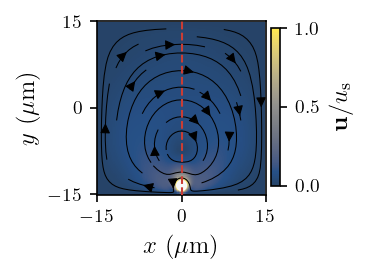

In [26]:
fig, axes = fluidOverview(fluidDf, True)
# plt.savefig("figs/figure1.png", format="png", transparent=True, dpi=72, bbox_inches="tight")
# plt.savefig("figs/figure1hd.png", format="png", transparent=True, dpi=300, bbox_inches="tight")

plt.show()

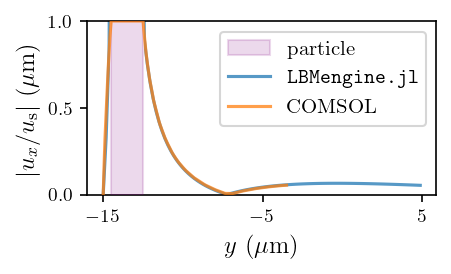

In [7]:
comsolResults = pd.read_csv('../data.lbm/comsolOutput.csv', delimiter=',')

# encuentro el primer id_x tal que coordinate_x sea mayor o igual a la posición de la partícula
position_x = particleDf.query(f'tick == {ticks[-1]}').position_x.values[0]
position_y = particleDf.query(f'tick == {ticks[-1]}').position_y.values[0]
id = fluidDf.query(f"coordinate_x >= {position_x}").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

fig, ax = plt.subplots(figsize = (3,1.5))

wallPosition = -15
# ax.axhline(1, color = 'k', alpha=0.5, linestyle='dashed', zorder=5) # tangential velocity (μm/ms)
ax.axvspan(position_y-particleRadius, position_y+particleRadius, color='white', alpha=1, zorder=2)  # Shade the sphere
ax.axvspan(position_y-particleRadius, position_y+particleRadius, color='purple', alpha=0.15, label='particle', zorder=3)  # Shade the sphere

ax.plot(v_x.query('coordinate_y < 5').coordinate_y, 1e6*abs(v_x.query('coordinate_y < 5').fluidVelocity_x), alpha=0.75, label = "\\texttt{LBMengine.jl}", zorder=1) 
ax.plot(comsolResults.coordinate_y - 15, comsolResults.fluidVelocity_x, alpha=0.75, label = "COMSOL", zorder=4) 
# ax.set_xlabel("$y$")
ax.set_xlabel("$y ~ (\\mu \\mathrm{m})$")
ax.set_xticks([-15, -5, 5])
# ax.set_ylabel("$|u_x|(x = 0)$")
ax.set_ylabel("$|u_x/u_\\mathrm{s}| ~ (\\mu \\mathrm{m})$")
ax.set_ylim(0., 1.0)
ax.set_yticks([-0, 0.5, 1])
# plt.title("$|u_x|$")
# plt.axvline(wallPosition, color = "k")
plt.legend()
# plt.savefig("figs/figure2.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Stability analysis

In an effort to verify a stable equilibrium state was achieved, the mean fluid speed is studied as a function of time.

In [8]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [9]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

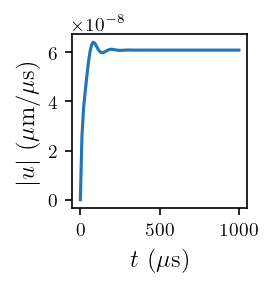

In [10]:
fig, ax = plt.subplots(figsize = (1.5,1.5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()

# Animation

In [40]:
# necessary directories are created
outputDir = f"frames"
os.system(f'mkdir -p anims')
os.system(f'mkdir -p {outputDir}')

for tickId in range(len(ticks)):
    fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[tickId]}.csv").set_index(["id_x","id_y"]).sort_index()
    time = fluidDf.time.values[-1]
    fig, axes = fluidOverview(fluidDf)
    fig.suptitle(f'$t = {time:.1f}$')

    plt.savefig(f"{outputDir}/{tickId}.png", format="png", dpi=300, bbox_inches="tight")
    plt.close()
    print(f'\r{tickId}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

0

In [42]:
# ffmpeg is used to create the animation
os.system('rm -f anims/output.mp4')
mkAnimSh = f'ffmpeg -framerate 15 -i {outputDir}/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p -loglevel quiet anims/output.mp4'
os.system(mkAnimSh)

0

In [43]:
# once I'm happy, the directory with the frames is erased
os.system(f'rm -r {outputDir}')

0